# Notebook for analysing the data from the UNHCR

Downloading the json data, inspect, silly predictions

In [1]:
import pandas as pd

import json
import requests
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

In [2]:
un_url = "https://data.unhcr.org/population/get/timeseries?widget_id=323622&sv_id=54&population_group=5460&frequency=day&fromDate=1900-01-01"

f = requests.get(un_url)
data = json.loads(f.text)

In [3]:
df = pd.DataFrame(data["data"]["timeseries"])
df

,data_date,unix_timestamp,individuals
0,2022-02-24,1645660800,79209
1,2022-02-25,1645747200,179525
2,2022-02-26,1645833600,322760
3,2022-02-27,1645920000,490433
4,2022-02-28,1646006400,652445
...,...,...,...
113,2022-06-17,1655424000,7786169
114,2022-06-18,1655510400,7843040
115,2022-06-19,1655596800,7899287
116,2022-06-20,1655683200,7950234


In [4]:
df.drop("unix_timestamp", axis=1, inplace=True)
df.describe()

,individuals
count,1.180000e+02
mean,4.953813e+06
std,2.007339e+06
min,7.920900e+04
25%,3.731356e+06
50%,5.201142e+06
75%,6.542753e+06
max,8.007014e+06


Sanity check: does this look like the data on the web?

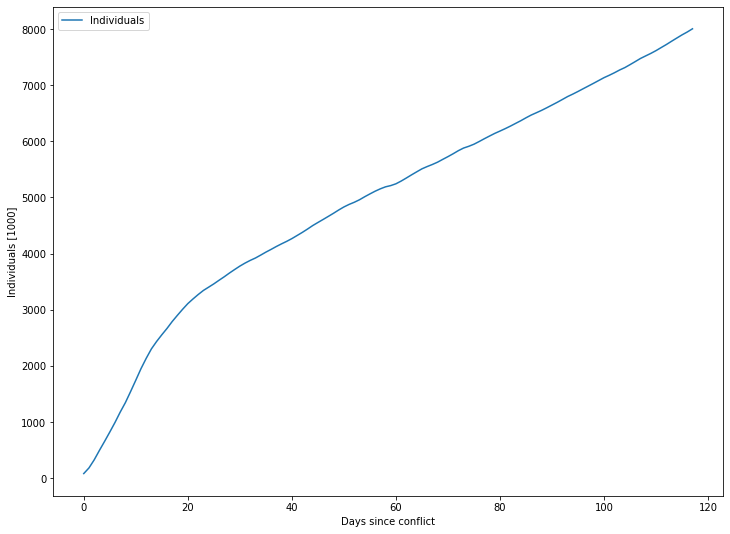

In [5]:
plt.plot(range(0, len(df)), df["individuals"]/1000, label="Individuals")
plt.xlabel("Days since conflict"); plt.ylabel("Individuals [1000]")
plt.legend(); 

In [6]:
individuals_daily = []
individuals_daily.append(df["individuals"][0])
for i in range(len(df)-1):
    c = df["individuals"][i+1] - df["individuals"][i]
    individuals_daily.append(c)

type(df["data_date"])

pandas.core.series.Series

In [7]:
s = pd.Series(individuals_daily, name="daily_individuals")
s

0       79209
1      100316
2      143235
3      167673
4      162012
        ...  
113     58306
114     56871
115     56247
116     50947
117     56780
Name: daily_individuals, Length: 118, dtype: int64

In [8]:
df["individuals_daily"] = s

In [9]:
df

,data_date,individuals,individuals_daily
0,2022-02-24,79209,79209
1,2022-02-25,179525,100316
2,2022-02-26,322760,143235
3,2022-02-27,490433,167673
4,2022-02-28,652445,162012
...,...,...,...
113,2022-06-17,7786169,58306
114,2022-06-18,7843040,56871
115,2022-06-19,7899287,56247
116,2022-06-20,7950234,50947


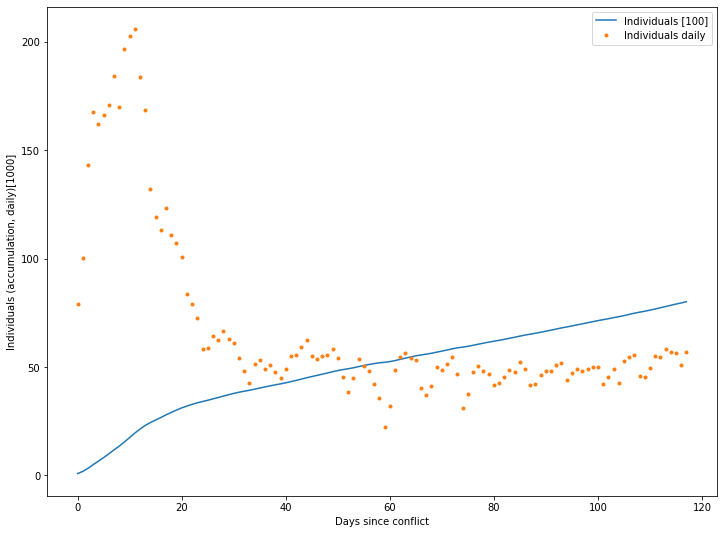

In [10]:
plt.plot(range(0, len(df)), df["individuals"]/100_000, label="Individuals [100]")
plt.plot(range(0, len(df)), df["individuals_daily"]/1000, ".", label="Individuals daily")
plt.xlabel("Days since conflict"); plt.ylabel("Individuals (accumulation, daily)[1000]")
plt.legend();

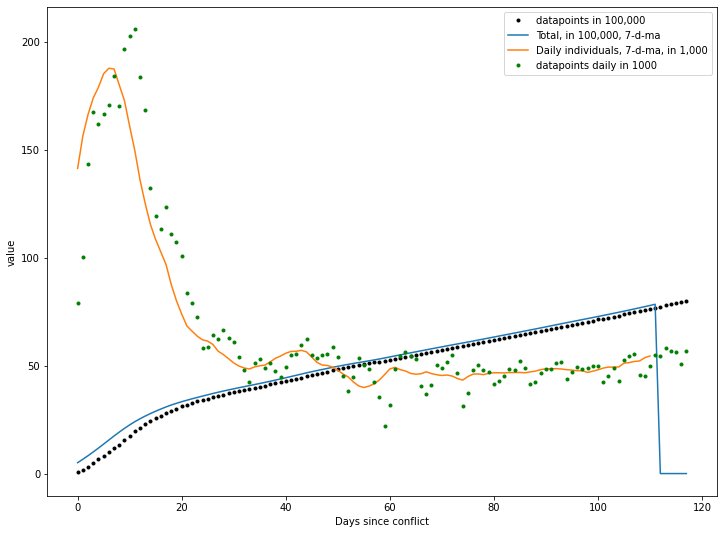

In [11]:
def moving_average(data, ma_window):
    moving_avg = data.copy()
    i = 0
    while i < len(data) - ma_window + 1:
        window = data[i : i+ma_window]
        moving_avg[i] = round(sum(window)/ma_window)
        i+=1
    moving_avg[i:len(data)+1] = 0
    return moving_avg

    
w = 7
ma7_arrivals = moving_average(df["individuals_daily"], w)
ma7_individuals = moving_average(df["individuals"], w)
plt.plot(df["individuals"]/100_000, "k.", label="datapoints in 100,000")
# strong indicator of no-data, cf line 18 "-w"
plt.plot(ma7_individuals[0:len(ma7_individuals)]/100000, label="Total, in 100,000, 7-d-ma") 
plt.plot(ma7_arrivals[0:len(ma7_arrivals)-w]/1000, label="Daily individuals, 7-d-ma, in 1,000") 
plt.plot(df["individuals_daily"]/1000, "g.", label="datapoints daily in 1000")
    
plt.xlabel("Days since conflict")
plt.ylabel("value")
plt.legend()

In [12]:
df["individuals_daily"][len(df)-7:]

111    54961
112    54396
113    58306
114    56871
115    56247
116    50947
117    56780
Name: individuals_daily, dtype: int64

In [13]:
print(f"7 day moving average of new arrivals is currentyl {ma7_arrivals[len(ma7_arrivals)-7]}.")
print("Latest day of new arrivals was at {}".format(df["individuals_daily"][len(df)-1]))

7 day moving average of new arrivals is currentyl 55501.
Latest day of new arrivals was at 56780


In [14]:
import numpy as np 
np.array(ma7_arrivals)

array([141366, 156354, 166324, 173958, 178936, 185221, 187718, 187384,
       179981, 172712, 160813, 149490, 135900, 124962, 115309, 108337,
       102568,  96754,  87465,  80020,  73863,  68362,  65931,  63624,
        61945,  61324,  59805,  56702,  55125,  53213,  51243,  49824,
        48913,  48428,  49390,  49912,  50248,  51739,  53355,  54439,
        55720,  56556,  56641,  57073,  56340,  53925,  51527,  50250,
        50072,  49307,  47854,  46153,  44760,  42442,  40609,  39857,
        40482,  41633,  43337,  45841,  48451,  49180,  48133,  47499,
        46401,  46008,  46231,  47152,  46316,  45773,  45430,  45648,
        45144,  44030,  43267,  44917,  46050,  46144,  45802,  46406,
        46686,  46684,  46617,  46784,  46772,  46830,  46672,  47100,
        47456,  48132,  48514,  48504,  48589,  48422,  48124,  47888,
        47642,  47637,  46845,  47399,  48039,  48840,  49318,  49306,
        49380,  51128,  51371,  51930,  52140,  53657,  54479,  55501,
      

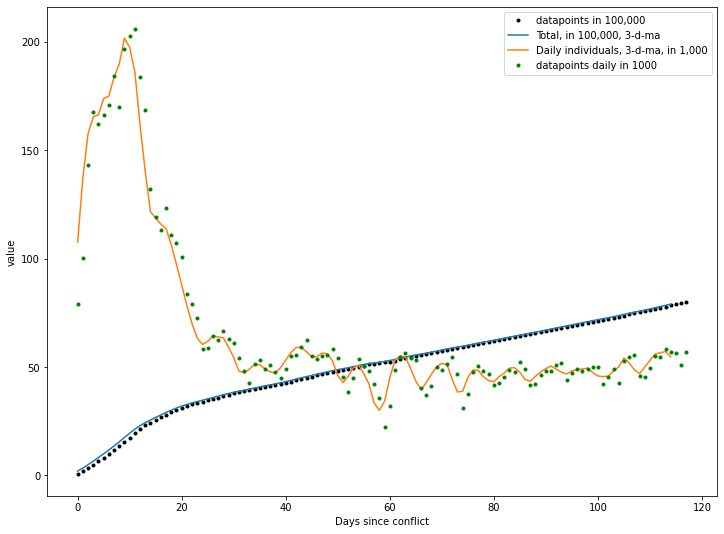

In [15]:
w = 3
ma3_new_arrivals = moving_average(df["individuals_daily"], 3)
ma3_individuals = moving_average(df["individuals"], 3)
plt.plot(df["individuals"]/100_000, "k.", label="datapoints in 100,000")
plt.plot(ma3_individuals[0:len(ma3_individuals)-w]/100000, label="Total, in 100,000, 3-d-ma")
plt.plot(ma3_new_arrivals[0:len(ma3_new_arrivals)-w]/1000, label="Daily individuals, 3-d-ma, in 1,000")
plt.plot(df["individuals_daily"]/1000, "g.", label="datapoints daily in 1000")
    
plt.xlabel("Days since conflict")
plt.ylabel("value")
plt.legend()

In [16]:
ma7_arrivals

0      141366
1      156354
2      166324
3      173958
4      178936
        ...  
113         0
114         0
115         0
116         0
117         0
Name: individuals_daily, Length: 118, dtype: int64